In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import joblib

In [ ]:
data = pd.read_csv('customer_data.csv')

In [ ]:
print("Columns in dataset:", data.columns.tolist())

Columns in dataset: ['CustomerID', 'OrderID', 'ProductInformation', 'TransactionAmount', 'PurchaseDate', 'Location']


In [ ]:
column_map = {}
for col in data.columns:
    if 'date' in col.lower():
        column_map[col] = 'purchase_date'
    elif 'amount' in col.lower():
        column_map[col] = 'order_value'
    elif 'customer' in col.lower():
        column_map[col] = 'customer_id'
data.rename(columns=column_map, inplace=True)

In [ ]:
print("Columns in dataset:", data.columns.tolist())

Columns in dataset: ['customer_id', 'OrderID', 'ProductInformation', 'order_value', 'purchase_date', 'Location']


In [ ]:
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [ ]:
reference_date = data['purchase_date'].max() + pd.Timedelta(days=1)
customer_features = data.groupby('customer_id').agg({
    'purchase_date': [lambda x: (reference_date - x.max()).days,  # Recency
                      lambda x: (x.max() - x.min()).days,          # Tenure
                      'count'],                                    # Frequency
    'order_value': ['sum', 'mean']                                # Monetary, AOV
})
customer_features.columns = ['recency', 'tenure', 'frequency', 'monetary', 'aov']
customer_features.reset_index(inplace=True)

In [ ]:
customer_features['ltv'] = customer_features['monetary']

In [ ]:
X = customer_features[['recency', 'tenure', 'frequency', 'aov']]
y = customer_features['ltv']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")

MAE: 4.19, RMSE: 14.99, R^2: 1.00


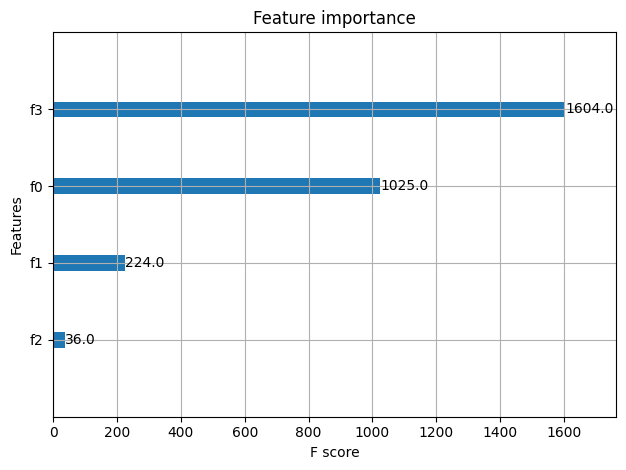

In [ ]:
xgb.plot_importance(model)
plt.tight_layout()
plt.show()

In [ ]:
customer_features['ltv_pred'] = model.predict(scaler.transform(X))
customer_features['segment'] = pd.qcut(customer_features['ltv_pred'], q=3, labels=['Low', 'Medium', 'High'])

In [ ]:
customer_features[['customer_id', 'ltv_pred', 'segment']].to_csv('ltv_predictions.csv', index=False)

In [ ]:
joblib.dump(model, 'ltv_model.pkl')
joblib.dump(scaler, 'ltv_scaler.pkl')

['ltv_scaler.pkl']